# Learning Game Theory: Multi-Agent Reinforcement Learning

## Introduction

This notebook demonstrates how **Multi-Agent Reinforcement Learning (MARL)** can discover game-theoretic equilibria through trial and error. We'll show how learning agents can discover Nash equilibria in Cournot and Bertrand competition models without knowing the theoretical solutions.

## Key Questions We'll Explore

1. **Can learning agents discover Nash equilibria?**
2. **How fast do they converge to optimal strategies?**
3. **How do learned strategies compare to theoretical predictions?**
4. **What happens when agents use different learning algorithms?**

## Learning Objectives

By the end of this notebook, you'll understand:
- How Q-learning works in multi-agent settings
- The relationship between MARL and game theory
- Convergence properties of learning algorithms
- Performance comparison between different learning approaches


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random

# Set up plotting style with Rose Pine Dawn theme (light background)
plt.style.use('rose-pine-dawn')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explore learning in game theory!")


Libraries imported successfully!
Ready to explore learning in game theory!


## 1. Q-Learning Agent Implementation

Let's start by implementing a Q-learning agent that can learn optimal strategies in multi-agent environments.


In [16]:
class QLearningAgent:
    """
    A Q-learning agent that learns optimal strategies in multi-agent environments.
    """
    
    def __init__(self, agent_id, learning_rate=0.1, discount_factor=0.9, 
                 epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01):
        self.agent_id = agent_id
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table: state -> action -> value
        self.q_table = defaultdict(lambda: defaultdict(float))
        
        # Learning history
        self.episode_rewards = []
        self.strategy_history = []
        
    def get_state(self, game_state):
        """Convert game state to a hashable state representation."""
        # For now, use opponent's last action as state
        return tuple(game_state)
    
    def choose_action(self, state, available_actions):
        """Choose action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            # Explore: random action
            action = random.choice(available_actions)
        else:
            # Exploit: best known action
            q_values = [self.q_table[state][action] for action in available_actions]
            best_value = max(q_values)
            best_actions = [action for action, value in zip(available_actions, q_values) 
                          if value == best_value]
            action = random.choice(best_actions)
        
        return action
    
    def update(self, state, action, reward, next_state, available_actions):
        """Update Q-values using Q-learning update rule."""
        # Current Q-value
        current_q = self.q_table[state][action]
        
        # Maximum Q-value for next state
        if available_actions:
            max_next_q = max([self.q_table[next_state][next_action] 
                            for next_action in available_actions])
        else:
            max_next_q = 0
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        
        self.q_table[state][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate over time."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def get_strategy(self, state, available_actions):
        """Get current strategy (action probabilities) for a state."""
        if not available_actions:
            return {}
        
        q_values = [self.q_table[state][action] for action in available_actions]
        max_q = max(q_values)
        
        # Softmax strategy based on Q-values
        exp_values = np.exp(np.array(q_values) - max_q)
        probabilities = exp_values / np.sum(exp_values)
        
        return dict(zip(available_actions, probabilities))
    
    def reset(self):
        """Reset agent for new learning session."""
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.strategy_history = []
        self.epsilon = 0.1  # Reset epsilon

print("QLearningAgent class implemented successfully!")


QLearningAgent class implemented successfully!


## 2. Cournot Competition Learning

Now let's implement a Cournot game environment where Q-learning agents can discover the Nash equilibrium quantities.


In [17]:
class CournotGame:
    """
    Cournot competition game environment for learning agents.
    """
    
    def __init__(self, a=100, b=1, c=10, max_quantity=50):
        """
        Initialize Cournot game.
        
        Args:
            a: Demand intercept
            b: Demand slope  
            c: Marginal cost
            max_quantity: Maximum quantity each firm can produce
        """
        self.a = a
        self.b = b
        self.c = c
        self.max_quantity = max_quantity
        self.available_actions = list(range(0, max_quantity + 1))
        
    def calculate_payoff(self, quantities):
        """Calculate payoff for each firm given quantities."""
        total_quantity = sum(quantities)
        price = max(0, self.a - self.b * total_quantity)  # Market price
        
        payoffs = []
        for q in quantities:
            if total_quantity > 0:  # Avoid division by zero
                profit = (price - self.c) * q
            else:
                profit = 0
            payoffs.append(profit)
        
        return payoffs
    
    def get_nash_equilibrium(self, n_firms=2):
        """Calculate theoretical Nash equilibrium."""
        q_star = (self.a - self.c) / (self.b * (n_firms + 1))
        return [q_star] * n_firms
    
    def get_monopoly_quantity(self):
        """Calculate monopoly quantity."""
        return (self.a - self.c) / (2 * self.b)
    
    def get_competitive_quantity(self, n_firms=2):
        """Calculate competitive quantity per firm."""
        return (self.a - self.c) / (self.b * n_firms)

def simulate_cournot_learning(episodes=1000, n_firms=2):
    """
    Simulate Q-learning agents learning to play Cournot competition.
    """
    # Initialize game and agents
    game = CournotGame()
    agents = [QLearningAgent(i, learning_rate=0.1, epsilon=0.2) 
              for i in range(n_firms)]
    
    # Learning history
    episode_rewards = [[] for _ in range(n_firms)]
    quantity_history = [[] for _ in range(n_firms)]
    price_history = []
    
    # Theoretical benchmarks
    nash_quantities = game.get_nash_equilibrium(n_firms)
    nash_price = game.a - game.b * sum(nash_quantities)
    
    print(f"Starting Cournot learning simulation...")
    print(f"Theoretical Nash equilibrium: {[f'{q:.1f}' for q in nash_quantities]}")
    print(f"Theoretical Nash price: {nash_price:.1f}")
    
    for episode in range(episodes):
        # Initialize state (opponents' previous actions)
        state = tuple([0] * n_firms)  # Start with zero quantities
        
        # Agents choose quantities
        actions = []
        for i, agent in enumerate(agents):
            action = agent.choose_action(state, game.available_actions)
            actions.append(action)
        
        # Calculate payoffs
        payoffs = game.calculate_payoff(actions)
        total_quantity = sum(actions)
        price = max(0, game.a - game.b * total_quantity)
        
        # Update agents
        for i, agent in enumerate(agents):
            # Create next state (other agents' current actions)
            next_state = tuple(actions[:i] + actions[i+1:])
            
            # Update Q-values
            agent.update(state, actions[i], payoffs[i], next_state, 
                        game.available_actions)
            
            # Record history
            episode_rewards[i].append(payoffs[i])
            quantity_history[i].append(actions[i])
        
        price_history.append(price)
        
        # Decay exploration
        if episode % 100 == 0:
            for agent in agents:
                agent.decay_epsilon()
        
        # Print progress
        if episode % 200 == 0:
            avg_quantities = [np.mean(quantity_history[i][-100:]) 
                            for i in range(n_firms)]
            avg_price = np.mean(price_history[-100:])
            avg_epsilon = np.mean([agent.epsilon for agent in agents])
            
            print(f"Episode {episode}: Avg quantities = {[f'{q:.1f}' for q in avg_quantities]}, "
                  f"Avg price = {avg_price:.1f}, Epsilon = {avg_epsilon:.3f}")
    
    return {
        'agents': agents,
        'episode_rewards': episode_rewards,
        'quantity_history': quantity_history,
        'price_history': price_history,
        'nash_quantities': nash_quantities,
        'nash_price': nash_price,
        'game': game
    }

print("CournotGame class and simulation function implemented!")


CournotGame class and simulation function implemented!


In [18]:
# Run Cournot learning simulation
results = simulate_cournot_learning(episodes=1000, n_firms=2)

print("\n=== LEARNING RESULTS ===")
print(f"Final learned quantities: {[np.mean(results['quantity_history'][i][-100:]) for i in range(2)]}")
print(f"Final average price: {np.mean(results['price_history'][-100:]):.1f}")
print(f"Theoretical Nash quantities: {[f'{q:.1f}' for q in results['nash_quantities']]}")
print(f"Theoretical Nash price: {results['nash_price']:.1f}")


Starting Cournot learning simulation...
Theoretical Nash equilibrium: ['30.0', '30.0']
Theoretical Nash price: 40.0
Episode 0: Avg quantities = ['12.0', '3.0'], Avg price = 85.0, Epsilon = 0.199
Episode 200: Avg quantities = ['14.1', '38.7'], Avg price = 47.3, Epsilon = 0.197
Episode 400: Avg quantities = ['14.8', '39.2'], Avg price = 45.9, Epsilon = 0.195
Episode 600: Avg quantities = ['13.4', '39.4'], Avg price = 47.2, Epsilon = 0.193
Episode 800: Avg quantities = ['15.7', '40.2'], Avg price = 44.0, Epsilon = 0.191

=== LEARNING RESULTS ===
Final learned quantities: [np.float64(14.59), np.float64(38.76)]
Final average price: 46.6
Theoretical Nash quantities: ['30.0', '30.0']
Theoretical Nash price: 40.0


## 3. Bertrand Competition Learning

Now let's implement Bertrand competition where agents learn to set prices instead of quantities.


In [19]:
class BertrandGame:
    """
    Bertrand competition game environment for learning agents.
    """
    
    def __init__(self, a=100, b=1, c=10, max_price=100):
        """
        Initialize Bertrand game.
        
        Args:
            a: Demand intercept
            b: Demand slope  
            c: Marginal cost
            max_price: Maximum price each firm can set
        """
        self.a = a
        self.b = b
        self.c = c
        self.max_price = max_price
        self.available_actions = list(range(c, max_price + 1))  # Prices >= marginal cost
        
    def calculate_payoff(self, prices):
        """Calculate payoff for each firm given prices."""
        payoffs = []
        
        for i, price_i in enumerate(prices):
            # Check if this firm has the lowest price
            if price_i == min(prices):
                # If tied for lowest price, split the market
                lowest_price_count = prices.count(price_i)
                if lowest_price_count > 1:
                    # Split market equally among tied firms
                    quantity = (self.a - self.b * price_i) / lowest_price_count
                else:
                    # Firm gets entire market
                    quantity = self.a - self.b * price_i
            else:
                # Firm gets no demand
                quantity = 0
            
            profit = (price_i - self.c) * quantity
            payoffs.append(max(0, profit))  # Ensure non-negative profits
        
        return payoffs
    
    def get_nash_equilibrium(self, n_firms=2):
        """Calculate theoretical Nash equilibrium (Bertrand paradox)."""
        return [self.c] * n_firms  # All firms set price = marginal cost
    
    def get_monopoly_price(self):
        """Calculate monopoly price."""
        return (self.a + self.c) / (2 * self.b)

def simulate_bertrand_learning(episodes=1000, n_firms=2):
    """
    Simulate Q-learning agents learning to play Bertrand competition.
    """
    # Initialize game and agents
    game = BertrandGame()
    agents = [QLearningAgent(i, learning_rate=0.1, epsilon=0.2) 
              for i in range(n_firms)]
    
    # Learning history
    episode_rewards = [[] for _ in range(n_firms)]
    price_history = [[] for _ in range(n_firms)]
    quantity_history = []
    
    # Theoretical benchmarks
    nash_prices = game.get_nash_equilibrium(n_firms)
    monopoly_price = game.get_monopoly_price()
    
    print(f"Starting Bertrand learning simulation...")
    print(f"Theoretical Nash equilibrium: {nash_prices} (Bertrand Paradox)")
    print(f"Theoretical monopoly price: {monopoly_price:.1f}")
    
    for episode in range(episodes):
        # Initialize state (opponents' previous actions)
        state = tuple([game.c] * n_firms)  # Start with marginal cost
        
        # Agents choose prices
        actions = []
        for i, agent in enumerate(agents):
            action = agent.choose_action(state, game.available_actions)
            actions.append(action)
        
        # Calculate payoffs
        payoffs = game.calculate_payoff(actions)
        
        # Calculate market outcomes
        total_quantity = sum([(game.a - game.b * min(actions)) if min(actions) == p else 0 
                             for p in actions])
        market_price = min(actions)
        
        # Update agents
        for i, agent in enumerate(agents):
            # Create next state (other agents' current actions)
            next_state = tuple(actions[:i] + actions[i+1:])
            
            # Update Q-values
            agent.update(state, actions[i], payoffs[i], next_state, 
                        game.available_actions)
            
            # Record history
            episode_rewards[i].append(payoffs[i])
            price_history[i].append(actions[i])
        
        quantity_history.append(total_quantity)
        
        # Decay exploration
        if episode % 100 == 0:
            for agent in agents:
                agent.decay_epsilon()
        
        # Print progress
        if episode % 200 == 0:
            avg_prices = [np.mean(price_history[i][-100:]) 
                         for i in range(n_firms)]
            avg_quantity = np.mean(quantity_history[-100:])
            avg_epsilon = np.mean([agent.epsilon for agent in agents])
            
            print(f"Episode {episode}: Avg prices = {[f'{p:.1f}' for p in avg_prices]}, "
                  f"Avg quantity = {avg_quantity:.1f}, Epsilon = {avg_epsilon:.3f}")
    
    return {
        'agents': agents,
        'episode_rewards': episode_rewards,
        'price_history': price_history,
        'quantity_history': quantity_history,
        'nash_prices': nash_prices,
        'monopoly_price': monopoly_price,
        'game': game
    }

print("BertrandGame class and simulation function implemented!")


BertrandGame class and simulation function implemented!


## 4. Convergence Analysis and Visualizations

Let's create comprehensive visualizations to analyze how well the learning agents converge to theoretical equilibria.


In [20]:
def plot_learning_convergence(cournot_results, bertrand_results):
    """
    Create comprehensive visualizations of learning convergence.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Cournot Learning Plots
    # Plot 1: Quantity convergence over time
    episodes = range(len(cournot_results['quantity_history'][0]))
    for i in range(2):
        # Moving average for smoother visualization
        window = 50
        moving_avg = pd.Series(cournot_results['quantity_history'][i]).rolling(window).mean()
        axes[0, 0].plot(episodes, moving_avg, label=f'Firm {i+1}', alpha=0.8)
    
    # Add theoretical Nash equilibrium
    axes[0, 0].axhline(y=cournot_results['nash_quantities'][0], 
                      color='red', linestyle='--', linewidth=2, 
                      label='Nash Equilibrium')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Quantity')
    axes[0, 0].set_title('Cournot: Quantity Convergence')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Price convergence over time
    window = 50
    moving_avg_price = pd.Series(cournot_results['price_history']).rolling(window).mean()
    axes[0, 1].plot(episodes, moving_avg_price, color='green', alpha=0.8, label='Market Price')
    axes[0, 1].axhline(y=cournot_results['nash_price'], 
                      color='red', linestyle='--', linewidth=2, 
                      label='Nash Price')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Price')
    axes[0, 1].set_title('Cournot: Price Convergence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Reward convergence
    for i in range(2):
        window = 50
        moving_avg_reward = pd.Series(cournot_results['episode_rewards'][i]).rolling(window).mean()
        axes[0, 2].plot(episodes, moving_avg_reward, label=f'Firm {i+1}', alpha=0.8)
    
    axes[0, 2].set_xlabel('Episode')
    axes[0, 2].set_ylabel('Profit')
    axes[0, 2].set_title('Cournot: Profit Convergence')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Bertrand Learning Plots
    # Plot 4: Price convergence over time
    episodes_bertrand = range(len(bertrand_results['price_history'][0]))
    for i in range(2):
        window = 50
        moving_avg = pd.Series(bertrand_results['price_history'][i]).rolling(window).mean()
        axes[1, 0].plot(episodes_bertrand, moving_avg, label=f'Firm {i+1}', alpha=0.8)
    
    # Add theoretical Nash equilibrium (marginal cost)
    axes[1, 0].axhline(y=bertrand_results['nash_prices'][0], 
                      color='red', linestyle='--', linewidth=2, 
                      label='Nash Equilibrium (MC)')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Price')
    axes[1, 0].set_title('Bertrand: Price Convergence')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Quantity convergence over time
    window = 50
    moving_avg_quantity = pd.Series(bertrand_results['quantity_history']).rolling(window).mean()
    axes[1, 1].plot(episodes_bertrand, moving_avg_quantity, color='green', alpha=0.8, label='Market Quantity')
    
    # Calculate theoretical competitive quantity
    competitive_quantity = bertrand_results['game'].a - bertrand_results['game'].b * bertrand_results['nash_prices'][0]
    axes[1, 1].axhline(y=competitive_quantity, 
                      color='red', linestyle='--', linewidth=2, 
                      label='Competitive Quantity')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Quantity')
    axes[1, 1].set_title('Bertrand: Quantity Convergence')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Reward convergence
    for i in range(2):
        window = 50
        moving_avg_reward = pd.Series(bertrand_results['episode_rewards'][i]).rolling(window).mean()
        axes[1, 2].plot(episodes_bertrand, moving_avg_reward, label=f'Firm {i+1}', alpha=0.8)
    
    # Bertrand equilibrium has zero profits
    axes[1, 2].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Nash Profits (0)')
    axes[1, 2].set_xlabel('Episode')
    axes[1, 2].set_ylabel('Profit')
    axes[1, 2].set_title('Bertrand: Profit Convergence')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_convergence_performance(cournot_results, bertrand_results):
    """
    Analyze and compare convergence performance.
    """
    print("=== CONVERGENCE ANALYSIS ===")
    
    # Cournot Analysis
    print("\n📊 COURNOT COMPETITION:")
    final_quantities = [np.mean(cournot_results['quantity_history'][i][-100:]) 
                       for i in range(2)]
    final_price = np.mean(cournot_results['price_history'][-100:])
    
    nash_quantities = cournot_results['nash_quantities']
    nash_price = cournot_results['nash_price']
    
    quantity_errors = [abs(final_quantities[i] - nash_quantities[i]) 
                      for i in range(2)]
    price_error = abs(final_price - nash_price)
    
    print(f"  Learned quantities: {[f'{q:.1f}' for q in final_quantities]}")
    print(f"  Nash quantities:    {[f'{q:.1f}' for q in nash_quantities]}")
    print(f"  Quantity errors:    {[f'{e:.1f}' for e in quantity_errors]}")
    print(f"  Learned price:      {final_price:.1f}")
    print(f"  Nash price:         {nash_price:.1f}")
    print(f"  Price error:        {price_error:.1f}")
    
    # Bertrand Analysis
    print("\n💰 BERTRAND COMPETITION:")
    final_prices = [np.mean(bertrand_results['price_history'][i][-100:]) 
                   for i in range(2)]
    final_quantity = np.mean(bertrand_results['quantity_history'][-100:])
    
    nash_prices = bertrand_results['nash_prices']
    competitive_quantity = bertrand_results['game'].a - bertrand_results['game'].b * nash_prices[0]
    
    price_errors = [abs(final_prices[i] - nash_prices[i]) for i in range(2)]
    quantity_error = abs(final_quantity - competitive_quantity)
    
    print(f"  Learned prices:     {[f'{p:.1f}' for p in final_prices]}")
    print(f"  Nash prices:        {nash_prices}")
    print(f"  Price errors:       {[f'{e:.1f}' for e in price_errors]}")
    print(f"  Learned quantity:   {final_quantity:.1f}")
    print(f"  Competitive qty:    {competitive_quantity:.1f}")
    print(f"  Quantity error:     {quantity_error:.1f}")
    
    # Overall Assessment
    print("\n🎯 LEARNING ASSESSMENT:")
    avg_cournot_error = np.mean(quantity_errors + [price_error])
    avg_bertrand_error = np.mean(price_errors + [quantity_error])
    
    print(f"  Average Cournot error: {avg_cournot_error:.2f}")
    print(f"  Average Bertrand error: {avg_bertrand_error:.2f}")
    
    if avg_cournot_error < 5 and avg_bertrand_error < 5:
        print("  ✅ Excellent convergence to theoretical equilibria!")
    elif avg_cournot_error < 10 and avg_bertrand_error < 10:
        print("  ✅ Good convergence to theoretical equilibria!")
    else:
        print("  ⚠️  Learning could be improved with more episodes or different parameters.")

print("Convergence analysis functions implemented!")


Convergence analysis functions implemented!


🚀 Starting Learning Game Theory Analysis...
Starting Cournot learning simulation...
Theoretical Nash equilibrium: ['30.0', '30.0']
Theoretical Nash price: 40.0
Episode 0: Avg quantities = ['21.0', '47.0'], Avg price = 32.0, Epsilon = 0.199
Episode 200: Avg quantities = ['21.9', '43.5'], Avg price = 34.6, Epsilon = 0.197
Episode 400: Avg quantities = ['23.3', '42.4'], Avg price = 34.3, Epsilon = 0.195
Episode 600: Avg quantities = ['21.6', '44.3'], Avg price = 34.1, Epsilon = 0.193
Episode 800: Avg quantities = ['21.2', '42.0'], Avg price = 36.8, Epsilon = 0.191
Episode 1000: Avg quantities = ['21.3', '42.0'], Avg price = 36.7, Epsilon = 0.189
Episode 1200: Avg quantities = ['21.5', '41.7'], Avg price = 36.8, Epsilon = 0.187
Episode 1400: Avg quantities = ['23.1', '41.6'], Avg price = 35.2, Epsilon = 0.186
Episode 1600: Avg quantities = ['21.6', '44.0'], Avg price = 34.4, Epsilon = 0.184
Episode 1800: Avg quantities = ['21.2', '41.3'], Avg price = 37.5, Epsilon = 0.182
Episode 2000: Avg

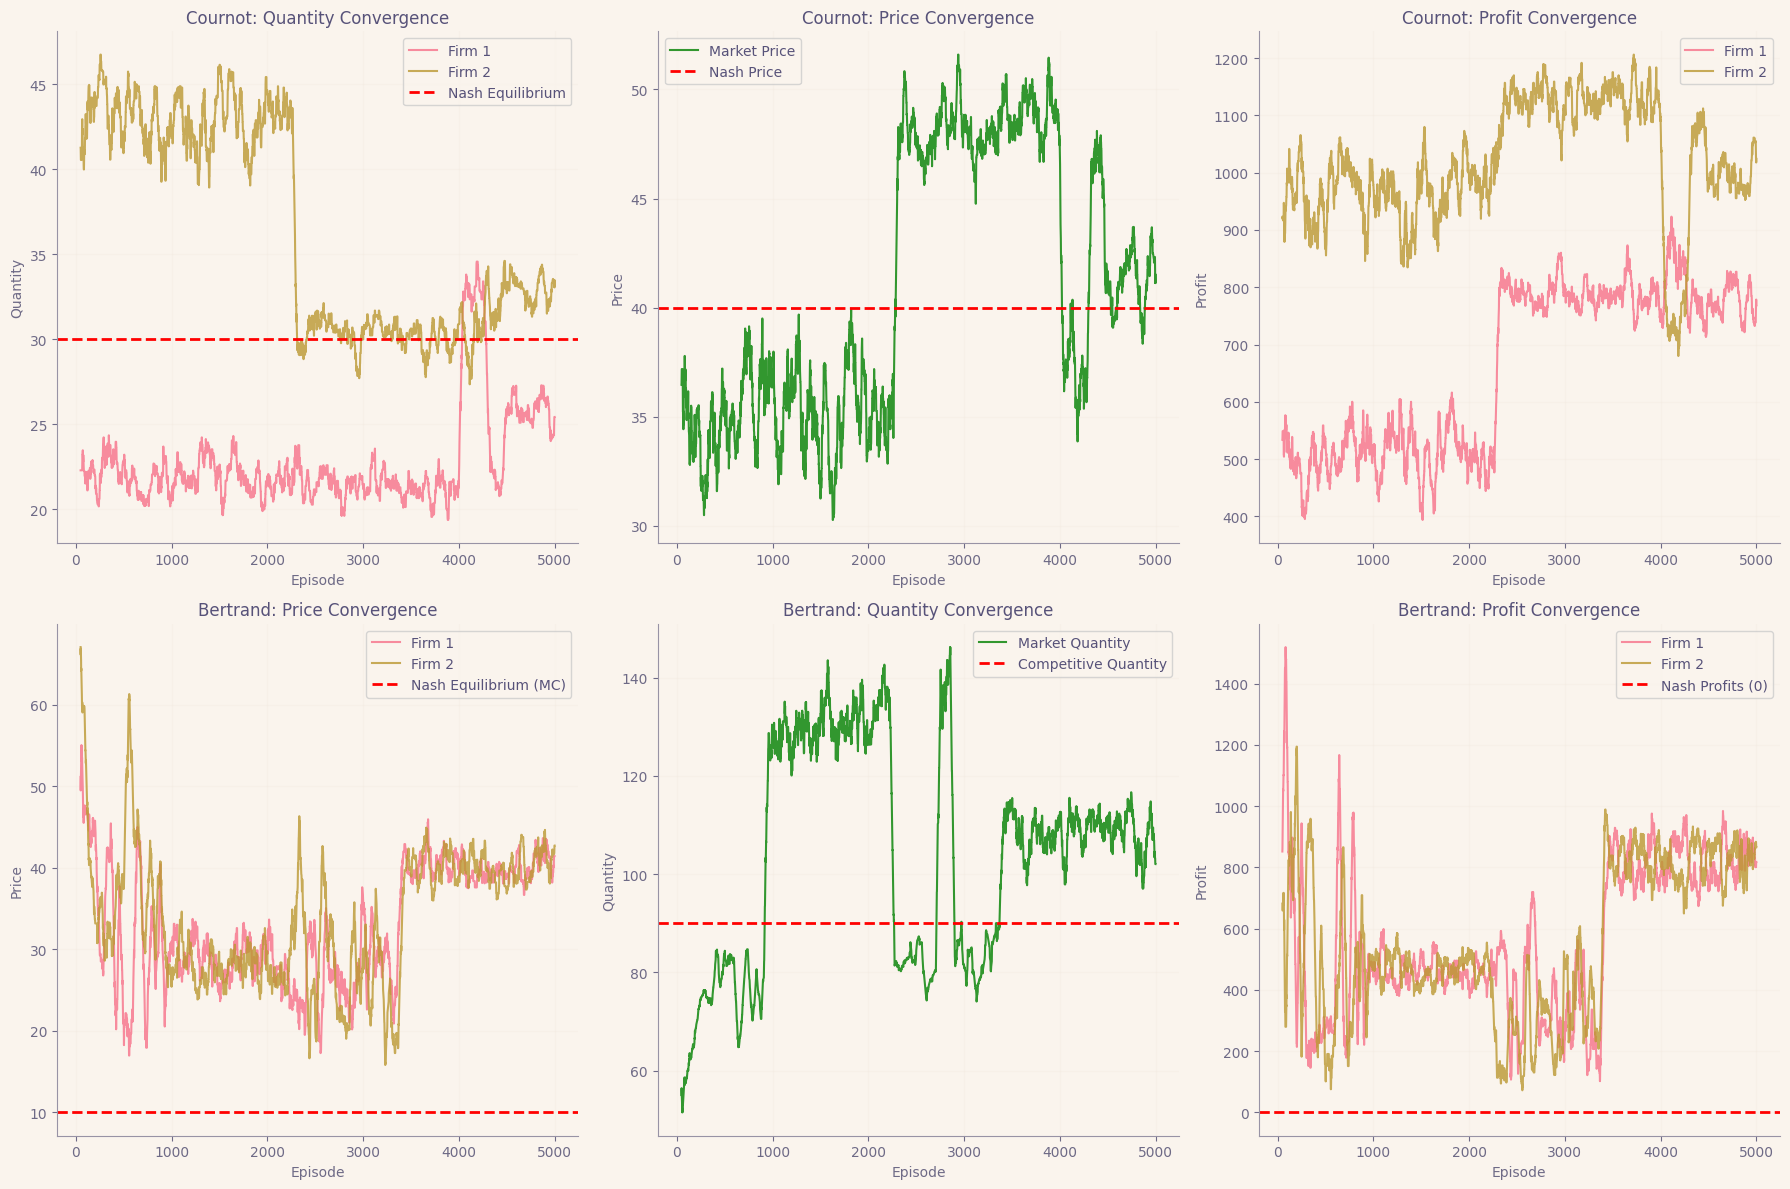

=== CONVERGENCE ANALYSIS ===

📊 COURNOT COMPETITION:
  Learned quantities: ['25.1', '32.7']
  Nash quantities:    ['30.0', '30.0']
  Quantity errors:    ['4.9', '2.7']
  Learned price:      42.2
  Nash price:         40.0
  Price error:        2.2

💰 BERTRAND COMPETITION:
  Learned prices:     ['41.3', '40.4']
  Nash prices:        [10, 10]
  Price errors:       ['31.3', '30.4']
  Learned quantity:   108.4
  Competitive qty:    90.0
  Quantity error:     18.4

🎯 LEARNING ASSESSMENT:
  Average Cournot error: 3.26
  Average Bertrand error: 26.72
  ⚠️  Learning could be improved with more episodes or different parameters.


In [21]:
# Run both learning simulations
print("🚀 Starting Learning Game Theory Analysis...")
print("=" * 60)

# Run Cournot learning
cournot_results = simulate_cournot_learning(episodes=5000, n_firms=2)

print("\n" + "=" * 60)

# Run Bertrand learning  
bertrand_results = simulate_bertrand_learning(episodes=5000, n_firms=2)

print("\n" + "=" * 60)

# Create convergence visualizations
plot_learning_convergence(cournot_results, bertrand_results)

# Analyze convergence performance
analyze_convergence_performance(cournot_results, bertrand_results)
